In [ ]:
import time

# Registre o início do fluxo de trabalho.
start_time = time.time()


# Fluxo de Trabalho para delimitação da poligonal para áreas de Avaliação, Desenvolvimento e Produção.

Autores: Marcelus Glaucus de Souza Araújo, 
         José Edmilson Vasconcelos dos Santos Junior &
         José Gilmar Alves Santos Junior

Colaboradores: Sérgio Ricardo Martins Soares &
               Stella Rodrigues Vaz
               
Data: 29/11/2023

In [ ]:
# Importação de bibliotecas
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
import warnings

from shapely.geometry import Polygon, Point, mapping
from geopandas.tools import overlay


#warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.filterwarnings("ignore",category=RuntimeWarning, message="The Shapely GEOS version")
pd.set_option('display.float_format', '{:.4f}'.format) # Define os valores com "n" casas decimais.
pd.options.plotting.backend = 'plotly'
plt.style.use('ggplot') # better for plotting geometries vs general plots.

## Carregamento de dados vetoriais de camada do tipo polígono ou multipolígono.

In [ ]:
# DADOS DE ENTRADA E CONFIGURAÇÃO DE PARÂMETROS

#subdiretório de dados
diretorio = 'dados_resultados' # endereço do diretório onde está o arquivo shapefile.
if os.path.isdir(diretorio):
    print("O diretório existe!")
else:
    os.mkdir(diretorio)
    print("O diretório 'resultados' foi criado!")
    
# carregamento de arquivos em formatos *.shp, *.gpkg e *.geojson

#filename = 'Limite_PreSal.shp'
filename = 'pol_muriu.shp'
nome = filename.split(".")[0]
nome_ext = filename.split(".")[1]





O diretório existe!


In [4]:
################################################################
# Geração do buffer entre 0 e 10.000 metros.
# O valor a ser digitado para "DISTANCIA_BUFFFER" deve estar 
# contido no intervalo fechado entre 0 e 10.000 (metros).
################################################################
dist_buffer = 1000
dist = "Buffer_" + str(dist_buffer)+ "_m"
################################################################

# Declaração de Instâncias de valor do grid em segundos.
grx = 9.375 #9.375             
gry = 9.375 #9.375

# Caminho para o arquivo:
# Estabelecee o diretório e subdiretório para a execução do algoritmo
path = Path('.') / diretorio

# Use os comandos abaixo caso existam polígonos que se sobreponham a área a ser gerada.
# O arquivo 'Bloco3.geojson' só tem compatibilidade de uso associado ao arquivo 'pol_muriu.shp'.
arquivo_recorte = '' # Use esta linha quando não houver arquivo para recorte.
#arquivo_recorte = (path / 'Bloco3.geojson') 

In [5]:
# Função para conversão de graus decimal para graus, minutos e
# segundos.
def graus_gms(val):
    positivo = (val >= 0)
    # val = abs(val) # não se deve alterar o parâmetro
    minutos, segundos = divmod(abs(val)*3600, 60)
    graus, minutos = divmod(minutos, 60)
    # graus = graus #if positivo else -graus

    if positivo:
        graus = "+%.0f:" % graus
    else:
        graus = "-%.0f:" % graus
    
    if minutos < 10:
        minutos = "0%.0f:" % minutos
    else:
        minutos = "%.0f:" % minutos
    
    if segundos <10:
        segundos = "0%.3f" % segundos
    else:
        segundos = "%.3f" % segundos
        
    coord = (graus +minutos +segundos)
    
    return (coord)


# muda epsg no arquivo
def prj(epsg, path_arquivo_shp):
    with  open( path_arquivo_shp, "a") as prj:
        prj.write(epsg)            

# Operação Topológica
def geoproc(gdf1, gdf2, opera):
    return overlay(gdf1, gdf2, how = opera, keep_geom_type=False)     

# Função para converter uma Linestring em Polygon
def linestring_to_polygon(line):
    # Converter a tupla de coordenadas para lista
    coords = list(line.coords)
    # Adiciona o ponto inicial no final da linha para fechar o polígono
    closed_line = coords + [coords[0]]
    # Cria o polígono
    polygon = Polygon(closed_line)
    return polygon


### O objetivo deste script é criar de forma automática o polígono delimitante para áreas em avaliação, desenvolvimento e produção, além de gerar arquivos de dados geoespaciais seguindo as premissas e normas vigentes da ANP em 03/11/2023. <justify>

* [Portal do Governo Brasileiro](https://www.gov.br/anp/pt-br/assuntos/exploracao-e-producao-de-oleo-e-gas/gestao-de-contratos-de-e-p/orientacoes-aos-concessionarios-e-contratados/coordenadas-para-delimitacao-de-areas)<br>
* [Padrão ANP4C, estabelecido pela Resolução ANP N° 70/2014.](https://www.gov.br/anp/pt-br/assuntos/exploracao-e-producao-de-oleo-e-gas/dados-tecnicos/legislacao-aplicavel/arquivos-legislacao-aplicavel/padrao_anp4c.pdf )<br>


## Atenção:

### Carregamento de dados em formato *.gpkg necessita de alteração dos parâmetros da célula abaixo.<justify>

In [6]:


# Obtendo valor da variável para uso na pasta de resultado dos dados.

if os.path.exists(arquivo_recorte):
    rec = '_recortado'
else:
    rec = ''
    
if grx == gry:
    s_grid = '_'+str(grx)+'_s'
else:
    s_grid = '_'+str(grx) + '_' + str(gry) +'_s'

path_resultados = path / ('resultados_'+ nome+ '_' + dist + s_grid + rec)
path_resultados.mkdir(exist_ok=True) # se não existir ele cria 


#path = '/tgeo/tgeo_1/users/...'
# Arquivo em formato geopackage
#gdf = gpd.read_file(path+'ILH.gpkg', layer='Limite_31983')

In [7]:
# Importando arquivo shape file para um geodataframe.
gdf = gpd.read_file( (path / filename))

# Verifica se a geometria é do tipo LineString
mask_linhas = gdf['geometry'].geom_type == 'LineString'

# Aplica a função de conversão de linha para polígono apenas nas linhas cuja geometria é LineString.
gdf.loc[mask_linhas, 'geometry'] = gdf[mask_linhas]['geometry'].apply(linestring_to_polygon)

# Exibe o GeoDataFrame 
#display(gdf)


In [8]:
CRS = gdf.crs

# Verificando se há problema com a geometria
# Caso o GeoDataFrame contenha ao menos uma geometria inválida, utilizaremos a operação com 
# buffer com valor nulo, para efetuar a correção automática da geometria. 

n=0
for p in gdf.is_valid:
    if p == True:
        m=0
    else:
        n=n+1
    if n > 0:
        gds = gdf.buffer(0)
        gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(gds))
        gdf = gdf.set_crs(CRS)

print()
print(f'Há {len(gdf)} conjunto(s) de polígono(s) no GeoDataFrame, sendo que {n} tem erro(s) interno(s) de geometria.')
print('----------------------')
print(gdf.is_valid)

# exemplo para importação de arquivo geopackage para um geodataframe.
#gdf = gpd.read_file((path / file_name), layer='mini_bacias')


gdf = gdf.explode(index_parts=True)
gdf = gdf.reset_index()
del(gdf['level_0'])
del(gdf['level_1'])


Há 1 conjunto(s) de polígono(s) no GeoDataFrame, sendo que 1 tem erro(s) interno(s) de geometria.
----------------------
0    True
dtype: bool


In [9]:
# visualização do Sistema de Referência de Coordenadas (SRC) do geodataframe ("gdf")
print(gdf.crs)

# Endereço que permite a identificação de códigos EPSG de SRC. Utilize palavras chaves. 
# https://epsg.io/ -->


# conversão para o Sistema de projeção Policônica Brasil (EPSG = 5880).
gdf_5880 = gdf.to_crs('epsg:5880')
print(gdf_5880.crs)

EPSG:31984
epsg:5880


In [10]:
# A distância máxima do buffer, inicialmente era de 1000 metros. Atualmente não há parâmetro 
# máximo definido. 'dn' é um valor arbitrado.
dn = 10000
if 0 < dist_buffer > dn:
    print('Valor digitado fora do intervalo previsto.\n' 
      'Digite novamente o valor de "dist_buffer", entre 0 e 1000 metros.')    
else:
    gds_5880_buf = gdf_5880.buffer(dist_buffer)
    gds_4674_buf = gds_5880_buf.to_crs("EPSG:4674")
    gdf_5880_buf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(gds_5880_buf))
    gdf_4674_buf = gdf_5880_buf.to_crs(4674)
    gdf_4674 = gdf.to_crs("EPSG:4674") 

# A projeção plana utilizada (EPSG:5880) é arbitrada e segue o que esta estabelecido na versão prévia do 
# Sigeo. Não existe definição de parâmetros para essa operação pelas normas ANP. 


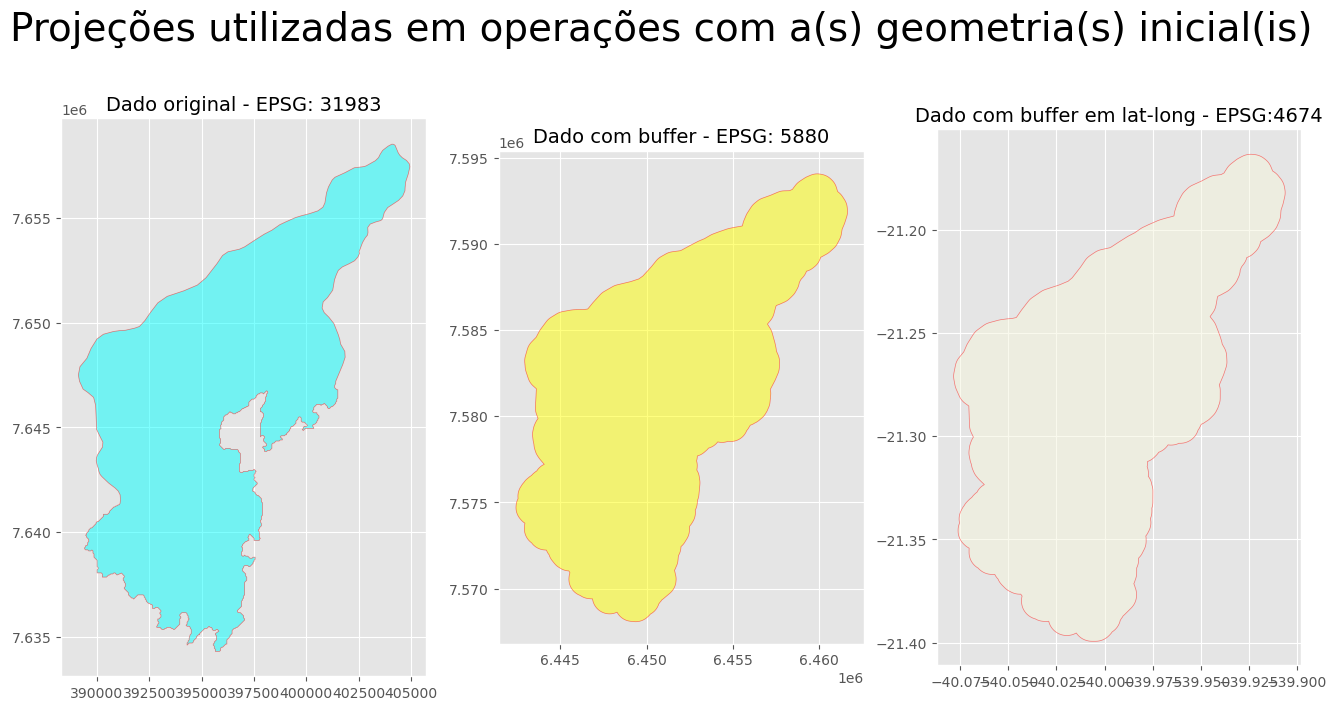

In [11]:
# Projeções utilizadas em operações com a(s) geometria(s) inicial(is)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8))
fig.suptitle('Projeções utilizadas em operações com a(s) geometria(s) inicial(is)', fontsize=28)
ax1 = gdf.plot(ax = ax1, color = 'cyan', alpha=0.5, edgecolor='red')
ax1.set_title("Dado original - EPSG: 31983", fontsize=14)
ax2 = gds_5880_buf.plot(ax = ax2, color='yellow', alpha=0.5, edgecolor='red')
ax2.set_title("Dado com buffer - EPSG: 5880", fontsize=14)
ax3 = gdf_4674_buf.plot(ax = ax3, color='beige', alpha=0.5, edgecolor='red')
ax3.set_title("Dado com buffer em lat-long - EPSG:4674", fontsize=14 )

figura=+1
plt.savefig(path_resultados/(nome + '_' + dist + '_Fig_plot_'+ str(figura) +'.png'))

In [12]:
# Obtendo valores dos limites do grid

dx = grx/3600        # conversão de valores para graus decimal.
dy = gry/3600

# Os valores de rx e ry são dependentes do hemisfério. No caso do Brasil, ambos são negativos.
rx = dx             
ry = dy
xmin, ymin, xmax, ymax = gdf_4674_buf.total_bounds

In [13]:
grxmin = np.arange(0, xmin+rx, -rx)
grxmax = np.arange(0, xmax-rx, -rx)
grymin = np.arange(0, ymin-ry, -ry)
grymax = np.arange(0, ymax+ry, -ry)

In [14]:
# Cálculo dos valores das coordenadas limítrofes a partir da grade de referência a 9,375".

grxmin = np.arange(0, xmin-2*rx, -rx)
grxmax = np.arange(0, xmax+2*rx, -rx)
grymin = np.arange(0, ymin-2*ry, -ry)
grymax = np.arange(0, ymax+2*ry, -ry)

#lim = (grxmin[-1], grxmax[-1], grymin[-1], grymax[-1],-r)

a = grxmin[-1]
b = grxmax[-1]
c = grymin[-1]
d = grymax[-1]

# coords = "%.12f, %.12f, %.12f, %.12f" % (a,b,c,d) #formato string

# a1 = graus_gms(a)
# b1 = graus_gms(b)
# c1 = graus_gms(c)
# d1 = graus_gms(d)

# print(a1,b1,c1,d1) # Notação de coordenadas conforme padrão ANP.

In [15]:
# Geração do grid de polígonos
linha = list(np.arange(a, b, dx))
coluna = list(np.arange(c, d, dy))

XleftOrigin = b - dx
XrightOrigin = b
YtopOrigin = d - dy
YbottomOrigin = d

Polygons = []

for i in range(len(linha)):
    Ytop = YtopOrigin
    Ybottom = YbottomOrigin

    for j in range(len(coluna)):
        polygon = [[XleftOrigin, Ytop], [XrightOrigin, Ytop], [XrightOrigin, Ybottom], [XleftOrigin, Ybottom]]
        Polygons.append(Polygon(polygon))
        Ytop = Ytop - dy
        Ybottom = Ybottom - dy
    
    XleftOrigin = XleftOrigin - dx
    XrightOrigin = XrightOrigin - dx

gdf_grid = gpd.GeoDataFrame({'geometry': Polygons}, crs="EPSG:4674")
gdf_grid['Nome'] = gdf_grid.index

In [16]:
# geração do gdf da totalidade dos vertices do grid.
X = []
Y = []
Xgms = []
Ygms = []

# Foram realizados ajustes em x e y para que os grids ficassem com as mesmas dimensões.
for x in np.arange(a, b+dx, dx):    
    for y in np.arange(c, d+dy, dy):        
        X.append(x)
        Y.append(y)        
        Xgms.append(graus_gms(x))
        Ygms.append(graus_gms(y))
        

idx = range(0,len(X))

df_pt = pd.DataFrame(
    {'Nome': idx,
     'lat': X,
     'long': Y,
     'lat_gms': Xgms,
     'long_gms': Ygms})

# df_pt
gdf_pt = gpd.GeoDataFrame(df_pt, geometry=gpd.points_from_xy(df_pt.lat, df_pt.long), crs='EPSG:4674')


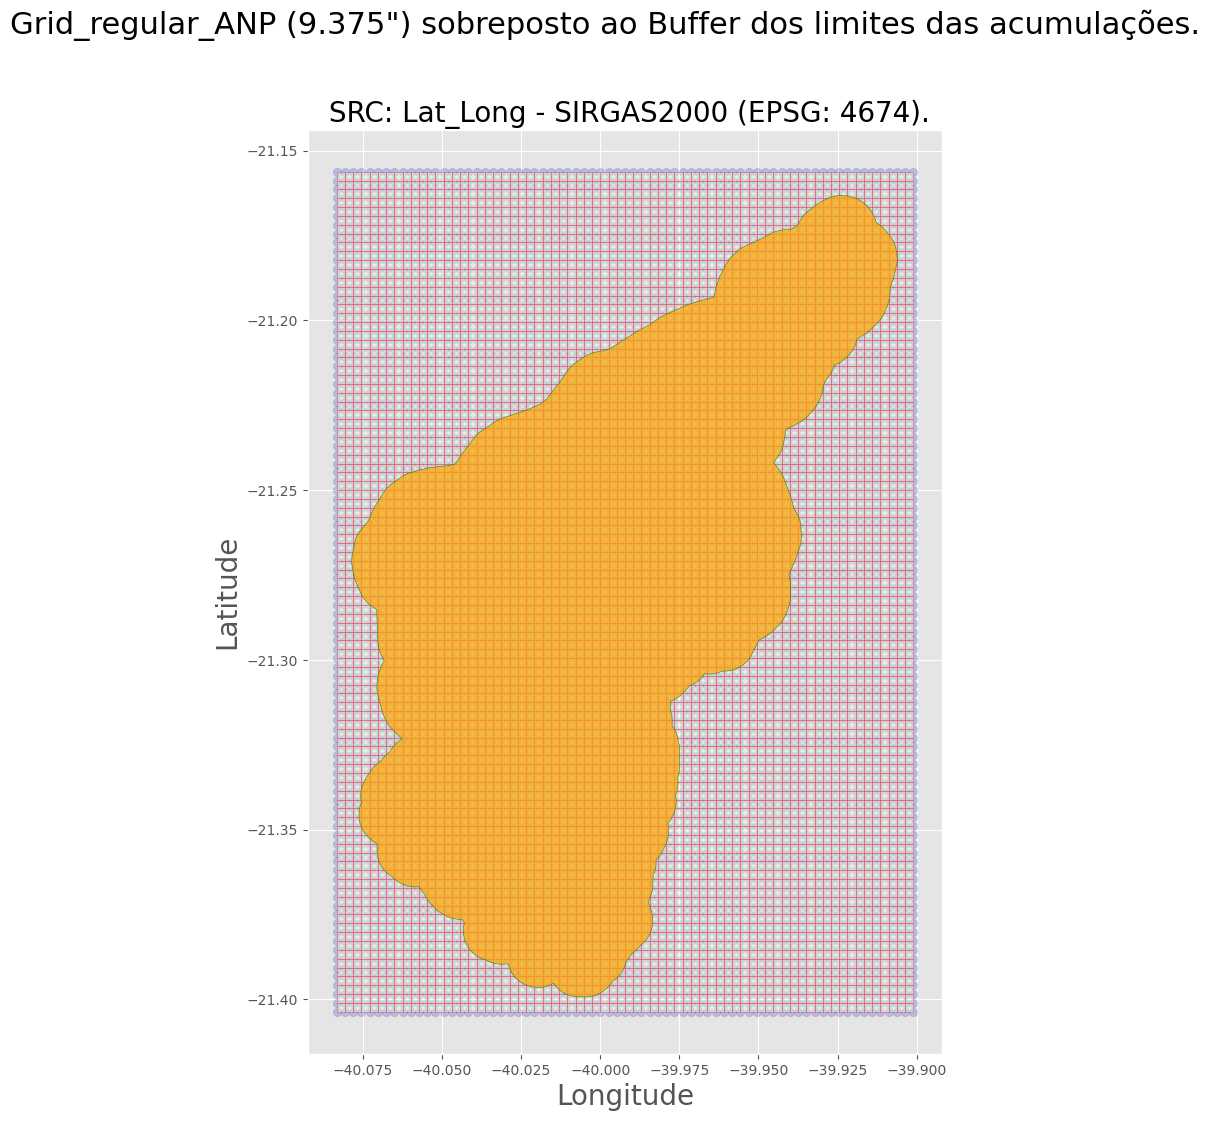

In [17]:
fig,ax1 = plt.subplots(figsize= (16,12))
fig.suptitle('Grid_regular_ANP (9.375") sobreposto ao Buffer dos limites das acumulações.', fontsize=22)
gdf_pt.plot(ax=ax1, color='b', alpha=0.2, edgecolor='g')
gdf_grid.plot(ax=ax1, color='beige', alpha=0.4, edgecolor='r')
gdf_4674_buf.plot(ax=ax1, color = 'orange', alpha=0.7, edgecolor='g')
plt.ylabel("Latitude", fontsize=20)
plt.xlabel("Longitude", fontsize=20)
ax1.set_title(" SRC: Lat_Long - SIRGAS2000 (EPSG: 4674).",  fontsize=20)


figura=figura+1
plt.savefig(path_resultados/(nome  + '_' + dist + '_Fig_plot_'+ str(figura) +'.png'))

In [18]:
newdf = geoproc(gdf_4674_buf, gdf_grid, 'intersection')
gdfx = (gdf_grid.loc[gdf_grid['Nome'].isin(newdf['Nome'])]).copy()
gdfx['level_0'] = 1
gdfx2 = gdfx.dissolve(by = 'level_0')
gdfx2['Nome'] = 'Pol_ANP_SIRGAS2000'

# separa o polígono multiparte em diferentes polígonos simples
gdfx2 = gdfx2.explode(index_parts=True)
gdfx2 = gdfx2.reset_index()
del(gdfx2['level_0'])
del(gdfx2['level_1'])


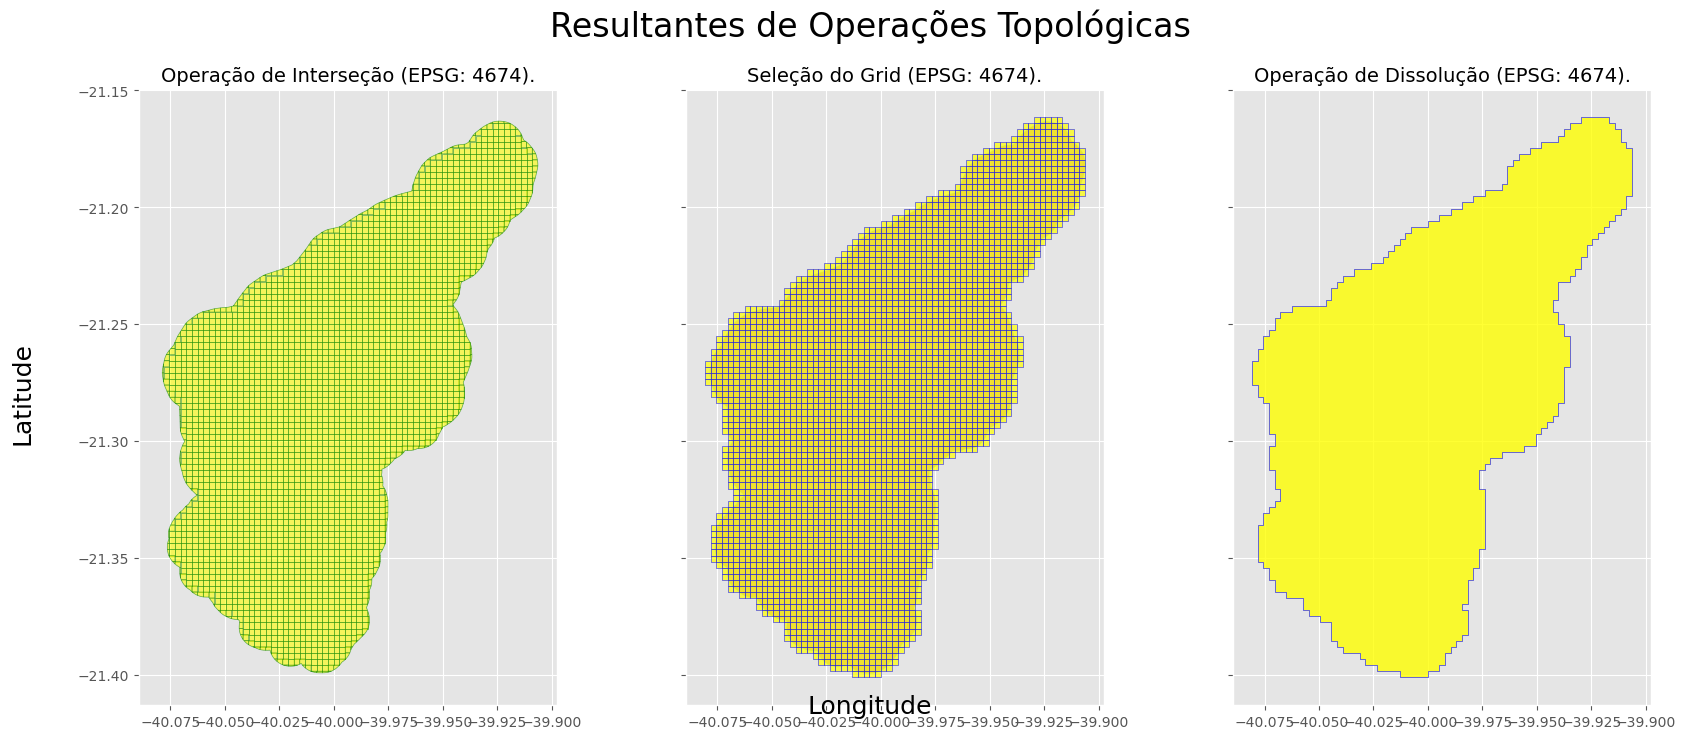

In [19]:
# Projeções utilizadas em operações com a(s) geometria(s) inicial(is)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, sharex = True, figsize=(20, 8))
fig.text(0.5, 0.1, 'Longitude', ha='center', fontsize=18)
fig.text(0.07, 0.5, 'Latitude', va='center', rotation='vertical', fontsize=18)
fig.suptitle('Resultantes de Operações Topológicas', fontsize=24)
ax1 = newdf.plot(ax = ax1, color = 'yellow', alpha=0.6, edgecolor='g')
ax1.set_title("Operação de Interseção (EPSG: 4674).", fontsize=14)
ax2 = gdf_4674_buf.plot(ax=ax2, color = 'brown', alpha=0.4, edgecolor='cyan')
ax2 = gdfx.plot(ax=ax2, color='yellow', alpha=0.7, edgecolor='b')
ax2.set_title("Seleção do Grid (EPSG: 4674).", fontsize=14 )
ax3 = gdfx2.plot(ax=ax3, color='yellow', alpha=0.8, edgecolor='b')
ax3.set_title("Operação de Dissolução (EPSG: 4674).", fontsize=14 )

figura=figura+1
plt.savefig(path_resultados/(nome  + '_' + dist + '_Fig_plot_'+ str(figura) +'.png'))


In [20]:
### Esta célula ainda não está automatizada.

#arquivo_recorte = '' # Use esta linha quando não houver arquivo para recorte.
#arquivo_recorte = (path / 'Bloco3.geojson')
if os.path.exists(arquivo_recorte):
    gdf_rec = gpd.read_file(arquivo_recorte)
    gdf_rec = gdf_rec.to_crs('EPSG:4674')
    gdf_rec = gdf_rec.explode()
    
    fig,ax = plt.subplots(figsize= (16,12))
    fig.suptitle('Sobreposições de polígonos a serem tratadas.', fontsize=20)
    ax.set_title(" SRC: Lat_Long - SIRGAS2000 (EPSG: 4674).",  fontsize=16)
    plt.ylabel("Latitude ", fontsize=16)
    plt.xlabel("Longitude", fontsize=16)
    ax = gdfx2.plot(ax=ax, color='yellow', alpha=0.8, edgecolor='b')
    gdf_rec.plot(ax = ax, color = 'red', alpha=0.2, edgecolor='cyan')
    figura=figura+1
    plt.savefig(path_resultados/(nome  + '_' + dist + '_Fig_plot_'+ str(figura) +'.png'))
    
    # Usuário deverá intervir aqui em função do número de polígonos (que será o número de operações)
    # o ordenamento e o tipo de operação(ões) topológicas a serem realizadas!
    gdf_op1 = geoproc(gdfx2, gdf_rec.iloc[:1], 'difference')
    gdf_op2 = geoproc(gdf_op1, gdf_rec.iloc[1:2], 'difference')
    gdf_op3 = geoproc(gdf_op2, gdf_rec.iloc[2:], 'intersection')
     
    gdf_ = gdf_op3.copy().explode()
    gdf_ = gdf_.reset_index()
    gdfx2 = gdf_[['Nome', 'geometry']]

    


In [21]:
# Criando um novo dataframe com as mesmas colunas do polígono
lista_vetores = []
for i in range(len(gdfx2)):
    p = gdfx2.loc[[i]]
    lista_vetores.append(p)


### Extração de coordenadas de vértices do(s) polígono(s) delimitantes e integração a um novo GeoDataFrame de pontos com novo número de vértices.

In [22]:
# Extração de coordenadas dos vértices dos polígonos e integração a um novo GeoDataFrame
def extrair_vertices(dataframe_pol):

    s = dataframe_pol.simplify(0.0001) # Redução de número de vértices.
    s2 = gpd.GeoDataFrame(geometry=gpd.GeoSeries(s))
    n_vertices=[]
    coord_valor = []
        
    for index, row in s2.iterrows():
        n_vertices=[]
        coord_valor = []
        for pt in list(row['geometry'].exterior.coords):
            coord_valor.append(pt)
        n_vertices = len(coord_valor)
        
    X = [coord_valor[i][0] for i in range(len(coord_valor))]
    Y = [coord_valor[i][1] for i in range(len(coord_valor))]
    
    X_gms = [graus_gms(coord_valor[i][0]) for i in range(len(coord_valor))]
    Y_gms = [graus_gms(coord_valor[i][1]) for i in range(len(coord_valor))]
    
    df = pd.DataFrame({'x_gdd': X, 'y_gdd': Y, 'x_gms': X_gms, 'y_gms': Y_gms})
    vert = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(X,Y), crs=4674)
    #vert = vert.drop_duplicates(['x_gdd', 'y_gdd'], keep='first')
    vert['Index'] = vert.index
    
    return vert



poligono_vertices = [extrair_vertices(p) for (p) in lista_vetores]

## Recriando gdf de polígono com atributos complementares conforme padrão ANP4C.

In [23]:
# lista contendo as coordenadas x e y 
def cria_geodataframe_ANP(vert):
    Vert = list(zip(vert.x_gdd, vert.y_gdd))

    p1 = Polygon(Vert)
    ggs = gpd.GeoSeries([p1])

    gdf_ANP  = gpd.GeoDataFrame(geometry=gpd.GeoSeries(ggs), crs = "EPSG:4674")

    
    gdf_ANP['Nome'] = 'Pol ANP'
    gdf_ANP['Vertices'] = len(Vert)
    gdf_ANP = gdf_ANP.set_crs("EPSG:4674")
    gdf_ANP = gdf_ANP.to_crs("EPSG:5880")
    gdf_ANP['Area_km2'] = round(gdf_ANP.area/1e6,4)
    gdf_ANP = gdf_ANP.to_crs("EPSG:4674")
    
    return gdf_ANP

poligono_gdf_ANP = [cria_geodataframe_ANP(vert) for vert in poligono_vertices]

for i in range(len(poligono_gdf_ANP)):
    poligono_gdf_ANP[i]['ID'] = i

In [24]:
def gera_pt_ajustado(gdf_ANP):
    gdf_ANP_5880 = gdf_ANP.to_crs("EPSG:5880")

    gds_ANP_buf = gdf_ANP_5880.buffer(1)

    gdf_ANP_int = gpd.GeoDataFrame(geometry=gpd.GeoSeries(gds_ANP_buf))
    gdf_ANP_int = gdf_ANP_int.to_crs("EPSG:4674")

    gdf_pt_ajuste = geoproc(gdf_pt, gdf_ANP_int, 'intersection')
    gdf_pt_ajuste = geoproc(gdf_pt_ajuste, gdf_4674, 'difference')

    return gdf_pt_ajuste

poligono_pt_ajuste = [gera_pt_ajustado(g) for g in poligono_gdf_ANP] 


# caso deseje visualizar a projeção dos vértices gerados
# poligono_pt_ajuste[0].plot()

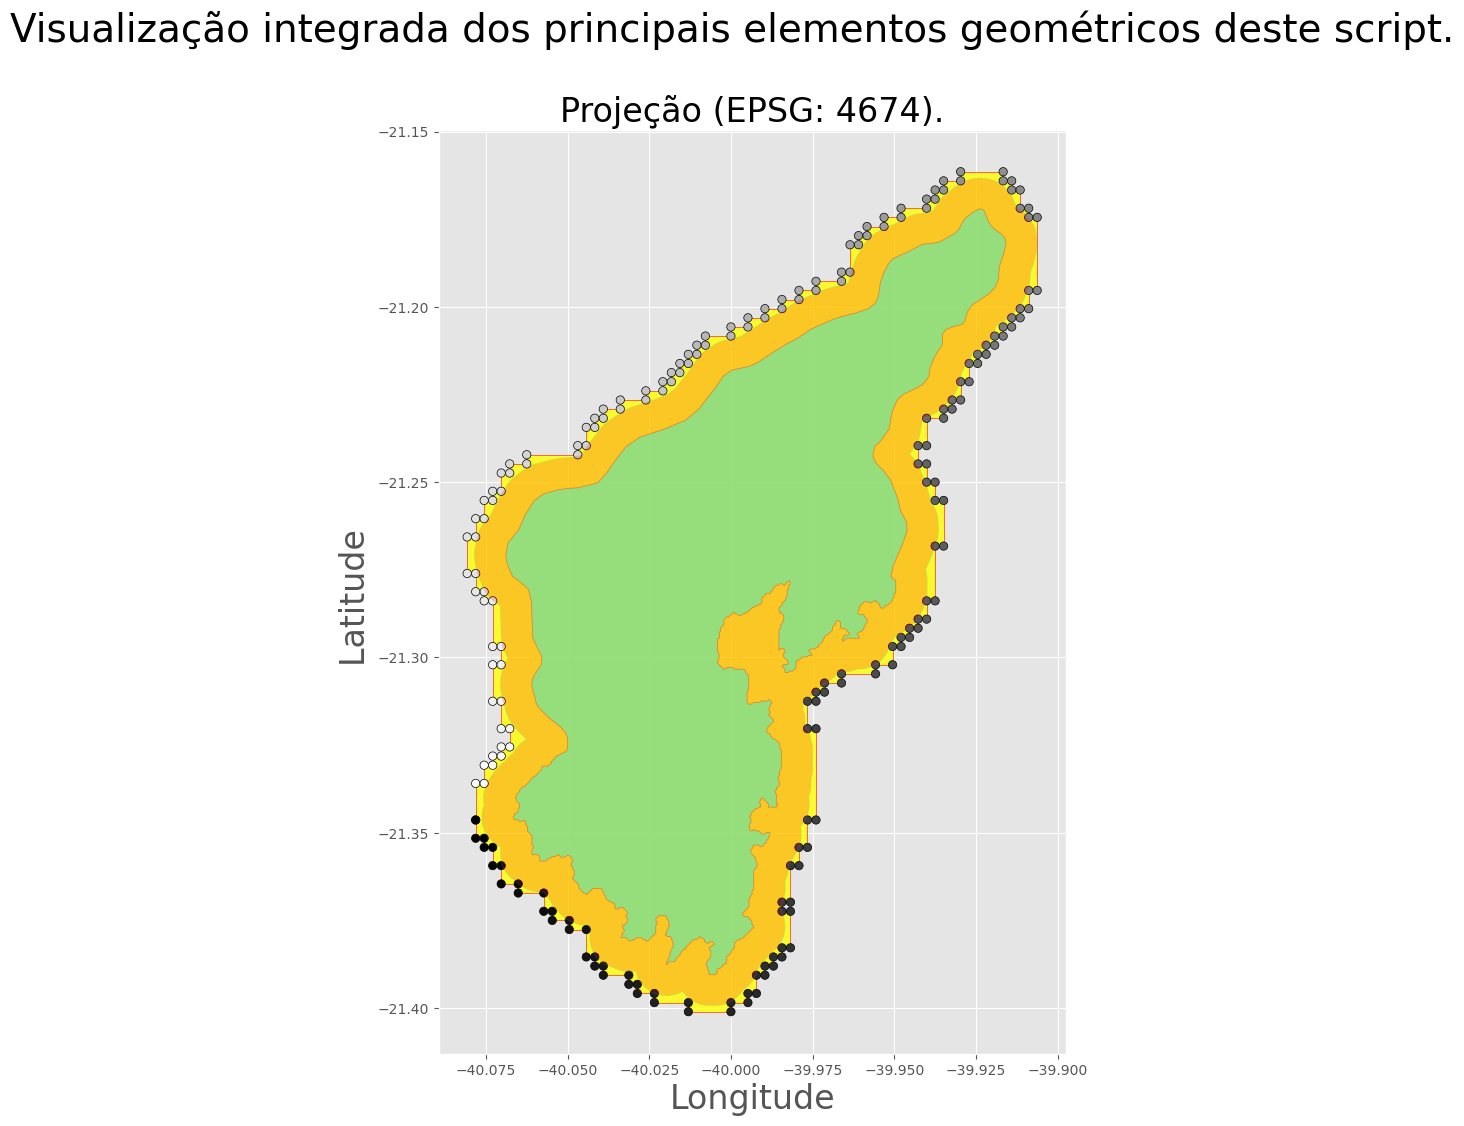

In [25]:
#gdf_4674 = gdf.to_crs("EPSG:4674")
fig,ax = plt.subplots(figsize= (16,12))
fig.suptitle('Visualização integrada dos principais' 
             ' elementos geométricos deste script.', fontsize=28)
             
for anp in poligono_gdf_ANP:
    anp.plot(ax=ax, color='yellow', alpha=0.8, edgecolor='r')

for vert in poligono_vertices:
    vert.plot(ax=ax, column='Index', alpha=1, cmap='gray_r', edgecolor='k')# legend=True)

plt.ylabel("Latitude ", fontsize=24)
plt.xlabel("Longitude", fontsize=24)

gdf_4674_buf.plot(ax = ax, color = 'red', alpha=0.2, edgecolor='cyan')

#if os.path.exists(arquivo_recorte):
#    gdf_rec.plot(ax = ax, color = 'blue', alpha=0.2, edgecolor='cyan')

gdf_4674.plot(ax=ax, color = 'cyan', alpha=0.4, edgecolor='red')

ax.set_title("Projeção (EPSG: 4674).", fontsize=24 );


figura=figura+1
plt.savefig(path_resultados/(nome  + '_' + dist + '_Fig_plot_'+ str(figura) +'.png'))

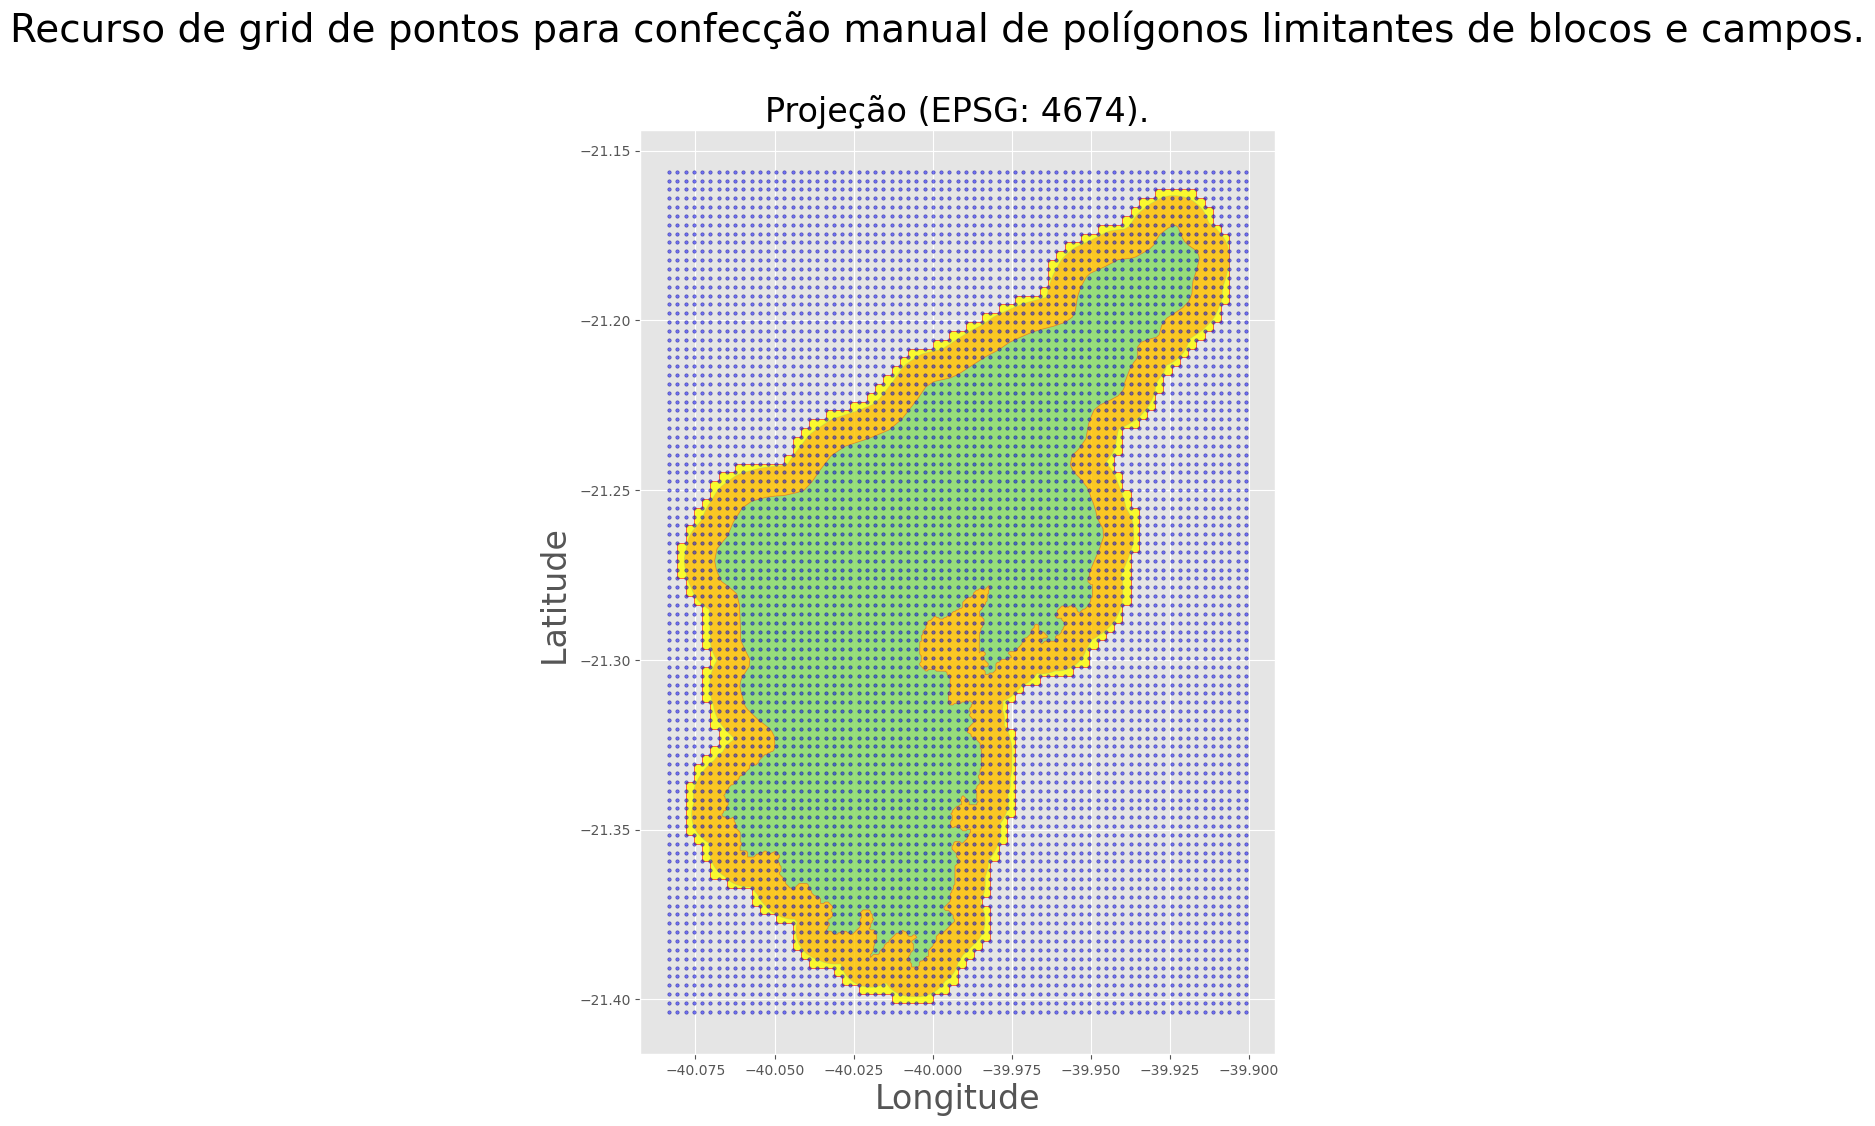

In [26]:
fig,ax = plt.subplots(figsize= (16,12))
fig.suptitle('Recurso de grid de pontos para confecção' 
             ' manual de polígonos limitantes de blocos e campos.', fontsize=28)
             
for anp in poligono_gdf_ANP:
    anp.plot(ax=ax, color='yellow', alpha=0.8, edgecolor='r')

#for vert in poligono_vertices:
#    vert.plot(ax=ax, column='Index', alpha=1, cmap='gray_r', edgecolor='k')#legend=True

plt.ylabel("Latitude ", fontsize=24)
plt.xlabel("Longitude", fontsize=24)

gdf_4674_buf.plot(ax = ax, color = 'red', alpha=0.2, edgecolor='cyan')

#if os.path.exists(arquivo_recorte):
#    gdf_rec.plot(ax = ax, color = 'blue', alpha=0.2, edgecolor='cyan')

gdf_4674.plot(ax=ax, color = 'cyan', alpha=0.4, edgecolor='red')
gdf_pt.plot(ax=ax, color='b', alpha=0.5, edgecolor='navy', markersize=6)


ax.set_title("Projeção (EPSG: 4674).", fontsize=24 );


figura=figura+1
plt.savefig(path_resultados/(nome  + '_' + dist + '_Fig_plot_'+ str(figura) +'.png'))

In [27]:
def gerar_dataframe_vertices_para_xls_anp(vert):
    df_vert = pd.DataFrame({'ident': 'Teste da fumarola azul',
                            'tipo': 'Polígono',
                            'vertice': 1+vert.index,
                            'lat': vert.y_gms,
                            'long': vert.x_gms,
                            'bacia': 'Santos'})

   
    # polígono gravado em shapefile tem valor igual para o primeiro e último vértice.
    df_vert['vertice'].iat[-1] = len(df_vert)
    df_vert['vertice'] = pd.to_numeric(df_vert['vertice'], downcast='integer')

    df_vert['lat'] = df_vert['lat'].astype(str)
    df_vert['lat'] = df_vert['lat'].str.replace('.', ',', regex=False)
    df_vert['long'] = df_vert['long'].astype(str)
    df_vert['long'] = df_vert['long'].str.replace('.', ',', regex=False)

    df_vert.columns = ["Identificacao_da_Feicao", "Tipo_da_Feicao", "Vertice", "Latitude", 
                        "Longitude","Bacia_Sedimentar"]   
    return df_vert


poligono_df_vertices = [gerar_dataframe_vertices_para_xls_anp(v) for v in poligono_vertices ]

poligono_vertices = [ vertx.set_crs('EPSG:4674') for vertx in poligono_vertices ]


In [28]:
#escreve os resultados
def gera_arquivos_shp(lista_vetor, caminho_arquivo):
    prj_4674 = '''GEOGCS["SIRGAS_2000",DATUM["D_SIRGAS_2000",SPHEROID["GRS_1980",\
    6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]]'''

    for numero, vert in enumerate(lista_vetor, start=1):
        arquivo = f"{caminho_arquivo}_{numero}.shp"
        vert.to_file( arquivo, mode='w')
        prj(prj_4674, arquivo )

for numero, df_vert in enumerate(poligono_df_vertices, start=1):
    df_vert.to_excel( path_resultados / (f"vertices_ANP_poligono_{numero}_{dist}.xlsx"), index=False )
    
# polígono final.
gera_arquivos_shp( poligono_gdf_ANP, path_resultados / (f"poligono_ANP_" + dist))

# Conjunto de dados a ser utilizado no SIGEO, caso o usuário deseje refazer o desenho a manualmente.

projeto =   diretorio  + '/'+ nome +'.gpkg'



for i in range(len(poligono_vertices)):
    poligono_vertices[i].to_file(path_resultados/(diretorio + '_'  + nome + '_' + dist +'.gpkg'), driver='GPKG', layer = nome + '_' + 
                                 'poligono_vertices_'+ str(i) + '_'+ dist)

for i in range(len(poligono_gdf_ANP)):
    poligono_gdf_ANP[i].to_file(path_resultados/(diretorio + '_' + dist +'.gpkg'), driver='GPKG', layer = nome + 
                                '_poligono_ANP_' + str(i) + '_' + dist)
    
gdf_pt.to_file(path_resultados/(diretorio + '_' + dist +'.gpkg'), driver='GPKG', layer = nome + '_grade_ANP_pontos_' + dist)
gdf_4674_buf.to_file(path_resultados/(diretorio + '_' + dist +'.gpkg'), driver='GPKG', layer = nome + '_gdf_4674_' + dist)
gdf.to_file(path_resultados/(diretorio + '_' + dist +'.gpkg'), driver='GPKG', layer = nome + '_corrigido')



In [29]:
# Fim da cronometragem para execução da rotina.
end_time = time.time()

# Calcule o tempo total de execução em segundos
execution_time = end_time - start_time

# Converta o tempo total de execução para uma representação mais legível, como HH:MM:SS
formatted_time = time.strftime("%H:%M:%S.%ms", time.gmtime(execution_time))

# Imprima o tempo total de execução
print(f"Tempo de execução: {formatted_time}")

Tempo de execução: 00:00:20.01s


In [30]:
# Visualização Extra. Não faz parte do algoritmo principal.

df = gpd.GeoDataFrame(pd.concat(poligono_gdf_ANP, ignore_index=True))
xm = (df.total_bounds[0]+df.total_bounds[2])/2
ym = (df.total_bounds[1]+df.total_bounds[3])/2
print(xm,ym)


import folium
from folium.plugins import MousePosition
mapa_int = folium.Map(location=[ym,xm], zoom_start=9) 

MousePosition().add_to(mapa_int)
for pol in poligono_gdf_ANP:
    mapa_int = pol.boundary.explore(m=mapa_int,color='red')
for pol in poligono_vertices:
    mapa_int = pol.explore(m=mapa_int, column = 'Index', cmap = 'gray',marker_type='circle_marker', marker_kwds={'radius':3}, legend=False)
mapa_int

-39.99348958333325 -21.281250000000064
